#  Install package

In [34]:
# ! pip install pyvis
# ! pip install networkx

# Import package

In [35]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai
from IPython.display import display, HTML, Code
from IPython.display import clear_output

# Define Solution class
Please run the following cell to define the functions

In [36]:
import LLM_Geo_Constants as constants
import helper

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration Cases

## Input task and data desciption

In [37]:
isReview = True

In [38]:

# Case 1: population living near hazardous wastes

# task_name ='Resident_at_risk_counting'

# TASK = r"""1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
# 2) Generate a population choropleth map for all tract polygons in NC, and then highlight the borders of tracts that have hazardous waste facilities. The map size is 15*10 inches.
# """

# DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip.",
#                   "NC tract boundary shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip. The tract ID column is 'GEOID', data types is integer.",
#                   "NC tract population CSV file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID', data types is integer."
#                  ]
 
# # Case 2: France_mobility_changes_2020
# task_name ='France_mobility_changes_2020'
# TASK = r'''
# 1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range (color scheme: coolwarm). The base of the change rate is January 2020. 
# 2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
# '''

# DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
#                   "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
#                   "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
#                   "REST API url with parameters for daily human mobility data access:" + \
#                   "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
#                   "The response is in CSV format. There are three columns in the response: " + \
#                   "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country;" + \
#                   "codes for France administrative regions start with 'FRA'. Use the total intra_movement of the month as the montly mobility.",
#                  ]

# # Case 3: COVID-19 death rate in US
task_name ='COVID_death_rate'
TASK = r'''1) Draw a choropleth  map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red.  Set figure size to 15*10 inches.  
'''


DATA_LOCATIONS = [
                  r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
                  r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'; map projection is EPSG:4269",
                  r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
                 ]




# # Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'
# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map of zipcode area polygons (unit: km), also show the hospital.
# '''

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


## Case 5: Census API
# task_name ='Census_API'
# TASK = r''' Show the spatial distribution of the county level median income in the contigous US. Set figure size to (25,15)
# '''

# DATA_LOCATIONS = [
#       "You can use the Census API.",
# ]


# DATA_LOCATIONS = [
# '''Census API key: ae7be70727932dd6aed257692de3f344365d0678'''              
# ]



save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. You have worked on Geographic 
information science more than 20 years, and know every detail and pitfall when processing spatial data and coding. You have significant experence on graph theory, application, and implementation. You are also experienced on generating map.
 

Your task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 1) Draw a  map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%

## Get graph code from GPT API

In [39]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx

G = nx.DiGraph()

# Step1: Load data
# 1.1 COVID 19 daily data
G.add_node("covid_19_daily_data_url", node_type="data", data_path="https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv", description="Daily accumulated COVID cases and deaths")
G.add_node("load_covid_19_daily_data", node_type="operation", description="Load COVID-19 daily data from URL")
G.add_edge("covid_19_daily_data_url", "load_covid_19_daily_data")

G.add_node("covid_19_daily_data_df", node_type="data", description="COVID-19 daily data loaded into pandas DataFrame")
G.add_edge("load_covid_19_daily_data", "covid_19_daily_data_df")

# 1.2 US counties shapefile
G.add_node("us_counties_shp_url", node_type="data", data_path="https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip",description="Contiguous US counties boundary shapefile URL")
G.add_node("load_us_counties_shp", node_type="operation", description="Load US counties boundary shapefile")
G.add_edge("us_counties_shp_url", "load_us_counties_shp")

G.add_node("us_counties_gdf", node_type="data", description="US counties boundary GeoDataFrame")
G.add_edge("load_us_counties_shp", "us_counties_gdf")

# 1.3 census data
G.add_node("census_data_url", node_type="data", data_path="https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv", description="US counties population census data URL")
G.add_node("load_census_data", node_type="operation", description="load US counties population census data")
G.add_edge("census_data_url", "load_census_data")

G.add_node("census_data_df", node_type="data", description="Census data loaded into pandas DataFrame")
G.add_edge("load_census_data", "census_data_df")


# Step 2: Preprocess data

# 2.1 Filter pipeline covid data
G.add_node("filter_covid_19_data", node_type="operation", 
description="Filter COVID-19 data for date 2020-12-31")
G.add_edge("covid_19_daily_data_df", "filter_covid_19_data")

G.add_node("filtered_covid_19_daily_df", node_type="data", 
description="Filtered COVID-19 data DataFrame")
G.add_edge("filter_covid_19_data", "filtered_covid_19_daily_df")

# 2.2 Join operation
G.add_node("join_operation", node_type="operation", 
description="Join census data with covid death/case rate and county shapefile data")
G.add_edge("filtered_covid_19_daily_df", "join_operation")
G.add_edge("census_data_df", "join_operation")
G.add_edge("us_counties_gdf", "join_operation")

G.add_node("dataframe_after_join", node_type="data", 
description="Joined dataframe: county shapefile data, census data and covid death rate")
G.add_edge("join_operation","dataframe_after_join" )


# Step 3: Generate figures
# 3.1 Map pipeline
G.add_node("death_rate_map", node_type="operation", description="Generate COVID-19 death rate map")
G.add_edge("dataframe_after_join", "death_rate_map")

G.add_node("death_rate_map_data", node_type="data", description="COVID-19 death rate map data")
G.add_edge("death_rate_map", "death_rate_map_data")

# 3.2 Scatter Plot pipeline
G.add_node("death_rate_scatter_plot", node_type="operation", description="Generate Scatter plot for death rate and the senior resident rate.")
G.add_edge("dataframe_after_join", "death_rate_scatter_plot")

G.add_node("death_rate_scatter_plot_data", node_type="data", description="Scatter plot data correlation between death rate and senior residents")
G.add_edge("death_rate_scatter_plot", "death_rate_scatter_plot_data")


# Save the graph into GraphML format
nx.write_graphml(G, "F:/Research/LLM-Geo/COVID_death_rate/COVID_death_rate.graphml")

## Execute code to generate the solution graph

In [40]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

F:\Research\LLM-Geo\COVID_death_rate.html


## Generate prompts and code for operations (functions)

In [41]:
operations = solution.get_LLM_responses_for_operations(review=isReview)
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

import pandas as pd

def load_covid_19_daily_data(covid_19_daily_data_url='https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv'):
    """
    This function loads COVID-19 daily data from a given URL.

    Parameters:
    covid_19_daily_data_url (str): The URL to the CSV data file.

    Returns:
    pd.DataFrame: Loaded data as a pandas DataFrame.
    """

    covid_19_daily_data_df = pd.read_csv(covid_19_daily_data_url)

    return covid_19_daily_data_df
def load_us_counties_shp(us_counties_shp_url='https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip'):
    '''
    Description: This function is used to load US counties boundary shapefile from a given url.
    Input: 
    - us_counties_shp_url (str): The url of the ESRI shapefile for US counties boundary. Default value is 'https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip'
    Output: 
    - us_counties_gdf (GeoDataFrame): The GeoDataFrame of the loaded US counties shapefile which includes US counties boundary spatial data.  
    '''
    import geopandas as gpd
    
    # Read the shapefile into GeoDataFrame
    us_counties_gdf = gpd.read_file(us_counties_shp_url)

    # Check the original map projection (CRS)
    original_crs = us_counties_gdf.crs

    # Convert the map projection to 'Conus Albers' (i.e., 'EPSG:5070') if needed
    if original_crs != 'EPSG:5070':
        us_counties_gdf = us_counties_gdf.to_crs('EPSG:5070')
    
    return us_counties_gdf
import pandas as pd

def load_census_data(census_data_url='https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv'):
    """ 
    Description: load US counties population census data

    Args:
    census_data_url : str 
      The URL link to access the US counties population census data. 
      The default link 'https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv' 
      has the needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 
      'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'.

    Returns:
    census_data_df : pandas.core.frame.DataFrame 
      A pandas DataFrame holding the US counties population census information. The used columns only, and drop rows with NaN in the loaded columns. 
    """
    # Define dtype for FIPS to keep leading zeros
    dtype={'FIPS': 'str'}
    # Define usecols to load necessary columns only
    usecols = ['FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 
               'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over']
               
    # Load Census data CSV from URL 
    census_data_df = pd.read_csv(census_data_url, dtype=dtype, usecols=usecols)
    
    # Drop rows with NaN in the loaded columns
    census_data_df = census_data_df.dropna()

    return census_data_df
def filter_covid_19_data(covid_19_daily_data_df):
    """
    This function filters COVID-19 data for date 2020-12-31.

    Parameters:
    covid_19_daily_data_df (pd.DataFrame): DataFrame of COVID-19 daily data.

    Returns:
    pd.DataFrame: Filtered data as a pandas DataFrame.
    """
    
    # Convert the 'date' column to datetime
    covid_19_daily_data_df['date'] = pd.to_datetime(covid_19_daily_data_df['date'])

    # Filter the data for date 2020-12-31
    filtered_covid_19_daily_df = covid_19_daily_data_df[covid_19_daily_data_df['date'] == '2020-12-31']

    return filtered_covid_19_daily_df
def join_operation(us_counties_gdf, census_data_df, filtered_covid_19_daily_df):
    '''
    Description: This function is to join census data with covid death/case rate and county shapefile data

    Input: 
    - us_counties_gdf (GeoDataFrame): The GeoDataFrame that contains US counties boundary spatial data.
    - census_data_df (DataFrame): The DataFrame that includes US census data.
    - filtered_covid_19_daily_df (DataFrame): The DataFrame of filtered covid 1

## Generate prompts and code for assembly program

In [42]:
assembly_LLM_response = solution.get_LLM_assembly_response(review=isReview)
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_assembly, language='python'))

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def load_covid_19_daily_data(covid_19_daily_data_url='https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv'):
    covid_19_daily_data_df = pd.read_csv(covid_19_daily_data_url)
    return covid_19_daily_data_df

def load_us_counties_shp(us_counties_shp_url='https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip'):
    us_counties_gdf = gpd.read_file(us_counties_shp_url)
    if us_counties_gdf.crs != 'EPSG:5070':
        us_counties_gdf = us_counties_gdf.to_crs('EPSG:5070')
    return us_counties_gdf

def load_census_data(census_data_url='https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv'):
    dtype={'FIPS': 'str'}
    usecols = ['FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over']
    census_data_df = pd.read_csv(census_data_url, dtype=dtype, usecols=usecols)
    census_data_df = census_data_df.dropna()
    return census_data_df

def filter_covid_19_data(covid_19_daily_data_df):
    covid_19_daily_data_df['date'] = pd.to_datetime(covid_19_daily_data_df['date'])
    filtered_covid_19_daily_df = covid_19_daily_data_df[covid_19_daily_data_df['date'] == '2020-12-31']
    return filtered_covid_19_daily_df

def join_operation(us_counties_gdf, census_data_df, filtered_covid_19_daily_df):
    filtered_covid_19_daily_df['death_rate'] = filtered_covid_19_daily_df['deaths'] / filtered_covid_19_daily_df['cases']
    filtered_covid_19_daily_df['fips'] = filtered_covid_19_daily_df['fips'].astype(str)
    filtered_covid_19_daily_df['fips'] = filtered_covid_19_daily_df['fips'].str.zfill(5)
    census_data_df['FIPS'] = census_data_df['FIPS'].astype(str)
    census_data_df['FIPS'] = census_data_df['FIPS'].str.zfill(5)
    dataframe_after_join_1 = pd.merge(filtered_covid_19_daily_df, census_data_df, left_on='fips', right_on='FIPS', how='inner')
    us_counties_gdf['GEOID'] = us_counties_gdf['GEOID'].astype(str)
    us_counties_gdf['GEOID'] = us_counties_gdf['GEOID'].str.zfill(5)
    dataframe_after_join_2 = gpd.GeoDataFrame(dataframe_after_join_1, geometry=gpd.points_from_xy(dataframe_after_join_1['Long'], dataframe_after_join_1['Lat']))
    dataframe_after_join = gpd.sjoin(dataframe_after_join_2, us_counties_gdf, how='inner', lsuffix='fips', rsuffix='GEOID')
    dataframe_after_join = dataframe_after_join.drop_duplicates()
    return dataframe_after_join

def death_rate_map(dataframe_after_join):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    dataframe_after_join.plot(column='death_rate', scheme='quantiles', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.set_title('COVID-19 Death Rate Among US Counties(as of 2020/12/31)', fontdict={'fontsize': '25', 'fontweight' : '3'})
    ax.annotate('Source: NYTimes and Census 2020',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    ax.set_axis_off()
    plt.axis('equal')
    fig.colorbar(plt.cm.ScalarMappable(cmap='YlOrRd'), ax=ax, orientation='horizontal', pad=0.01, aspect=400, fraction=0.1)
    death_rate_map_data = plt.gcf()
    death_rate_map_data.savefig('death_rate_map.png', dpi=300)
    return death_rate_map_data

def death_rate_scatter_plot(dataframe_after_join):
    dataframe_after_join['Senior Resident Rate'] = (dataframe_after_join['Total Population: 65 to 74 Years'] + dataframe_after_join['Total Population: 75 to 84 Years'] + dataframe_after_join['Total Population: 85 Years and Over']) / dataframe_after_join['Total Population']
    plt.figure(figsize=(15,10))
    subplot = sns.scatterplot(data=dataframe_after_join, x='Senior Resident Rate', y='death_rate', alpha=0.5)
    plt.xlabel('Senior Resident Rate')
    plt.ylabel('Death Rate')
    plt.title('Correlation of Death Rate and Senior Resident Rate fo

## Execute assembly code



-------------- Running code (trial # 1/10) --------------




Complete program:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_name = operation['node_name']
Complete program:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
Complete program:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # get ancestors code


Error_info_str: 
Traceback (most recent call last):
  File "Complete program", line 283, in <module>
    assembely_solution()
  File "Complete program", line 277, in assembely_solution
    dataframe_after_join = join_operation(us_counties_gdf, census_data_df, filtered_covid_19_daily_df)
  File "Complete program", line 242, in join_operation
    dataframe_after_join_2 = gpd.GeoDataFrame(dataframe_after_join_1, geometry=gpd.points_from_xy(dataframe_after_join_1['Long'], dataframe_after_join_1['Lat']))
  File "d:\ProgramData\anaconda3\envs\llm_geo\Lib\site-packages\pandas\core\frame.py", line 3896, in __getitem__
    indexer = self.columns.get_loc(key)
  File "d:\ProgramData\anaconda3\envs\llm_geo\Lib\site-packages\pandas\core\indexes\base.py", line 3797, in get_loc
    raise KeyError(key) from err
KeyError: 'Long'

Sending error information to LLM for debugging...
The error in the given code occurs due to an attempt to access the 'Long' and 'Lat' columns from `dataframe_after_join_1` whi

Complete program:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stream=True,
Complete program:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verbose=True,
Complete program:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ):


Error_info_str: 
Traceback (most recent call last):
  File "Complete program", line 78, in <module>
    assembely_solution()
  File "Complete program", line 72, in assembely_solution
    dataframe_after_join = join_operation(us_counties_gdf, census_data_df, filtered_covid_19_daily_df)
  File "Complete program", line 38, in join_operation
    dataframe_after_join = gpd.sjoin(us_counties_gdf, dataframe_after_join_1, how='inner', lsuffix='GEOID', rsuffix='fips')
  File "d:\ProgramData\anaconda3\envs\llm_geo\Lib\site-packages\geopandas\tools\sjoin.py", line 119, in sjoin
    _basic_checks(left_df, right_df, how, lsuffix, rsuffix)
  File "d:\ProgramData\anaconda3\envs\llm_geo\Lib\site-packages\geopandas\tools\sjoin.py", line 152, in _basic_checks
    raise ValueError(
ValueError: 'right_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

Sending error information to LLM for debugging...
The traceback error is caused by using GeoPandas sjoin() function to join a GeoDataFra

Complete program:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model=r"gpt-3.5-turbo",
Complete program:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verbose=True,
Complete program:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ):
Complete program:33: SettingWithCopyWarning: 
A value is trying to be set on a copy



--------------- Done ---------------




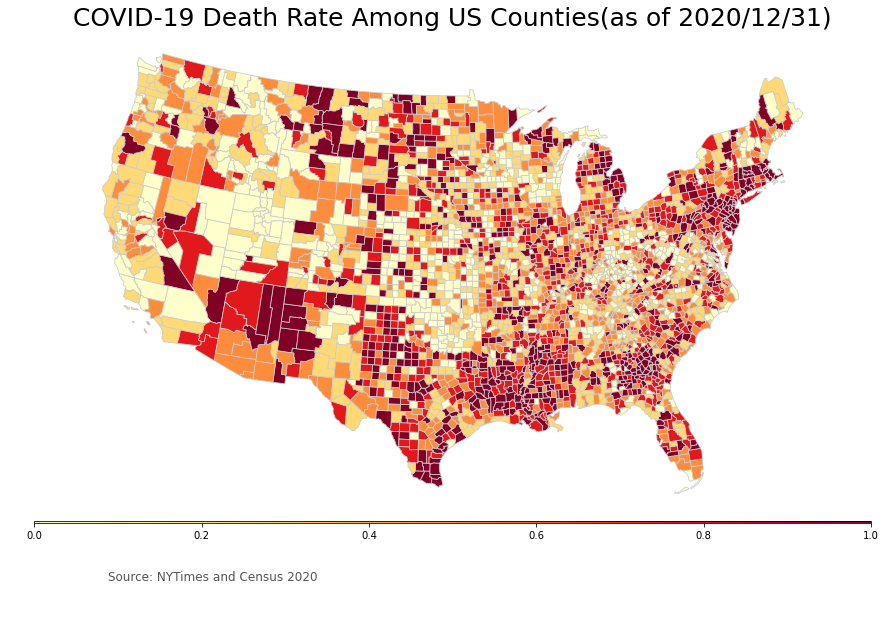

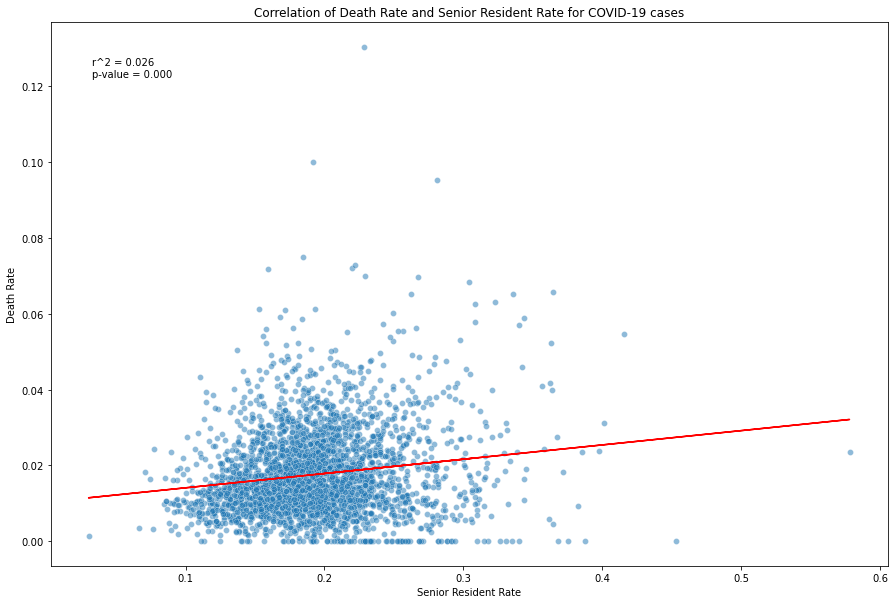

In [43]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))

all_code = solution.execute_complete_program(code=all_code, try_cnt=10)

In [44]:
# pip install seaborn